In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

palette = sns.color_palette("colorblind")
sns.set_palette(palette)

In [109]:
df = pd.read_csv('dataset_doc_quant_data_final.csv')
print(f"Dataset shape: {df.shape}")
print(f"Number of entries: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("Column names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
df.head()

Dataset shape: (59, 13)
Number of entries: 59
Number of features: 13
Column names:
['name', 'authors', 'year', 'prior_user_research', 'If study was used, type of study used', 'audiences', 'stakeholders_mentioned', 'stakeholders_involved', 'What is the precise context of use of the tool as presented by authors\n', 'tool_evaluation', 'degree_automation', 'tool_integration', 'tool_description']

Data types:
name                                                                        object
authors                                                                     object
year                                                                         int64
prior_user_research                                                         object
If study was used, type of study used                                       object
audiences                                                                   object
stakeholders_mentioned                                                      object
stakeholder

,name,authors,year,prior_user_research,"If study was used, type of study used",audiences,stakeholders_mentioned,stakeholders_involved,What is the precise context of use of the tool as presented by authors\n,tool_evaluation,degree_automation,tool_integration,tool_description
0,Data Statements | Tech Policy Lab,"McMillan-Major, Angelina; Bender, Emily M.",2023,No,This paper is about Data Statements version 3\...,"dataset creators, dataset users",Yes,No,linguistic contexts primarily but could be bro...,No,Manual,No,toolkit
1,The Dataset Nutrition Label: A Framework To Dr...,"Holland, Sarah; Hosny, Ahmed; Newman, Sarah; J...",2018,Yes,I am saying yes even though the study was not ...,dataset creators,Yes,Yes,Their intention overall is to be context-indep...,No,Hybrid,No,framework
2,Towards accountability for machine learning da...,"Hutchinson, Ben; Smart, Andrew; Hanna, Alex; D...",2021,No,NaN,dataset creators,Yes,No,"Artificial Ingeligence, \nMachine Learning dat...",No,Manual,No,framework
3,Understanding machine learning practitioners' ...,"Heger, Amy K.; Marquis, Liz B.; Vorvoreanu, Mi...",2022,NaN,This is a n empirical study of existing datase...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,study
4,A generative benchmark creation framework for ...,"Fox, Daniel C.; Khatiwada, Aamod; Shraga, Roee",2024,No,NaN,dataset creators,No,No,"No precise context is described, there are onl...",No,Automated,No,framework


# Figure 1: Type of tool, automation, years

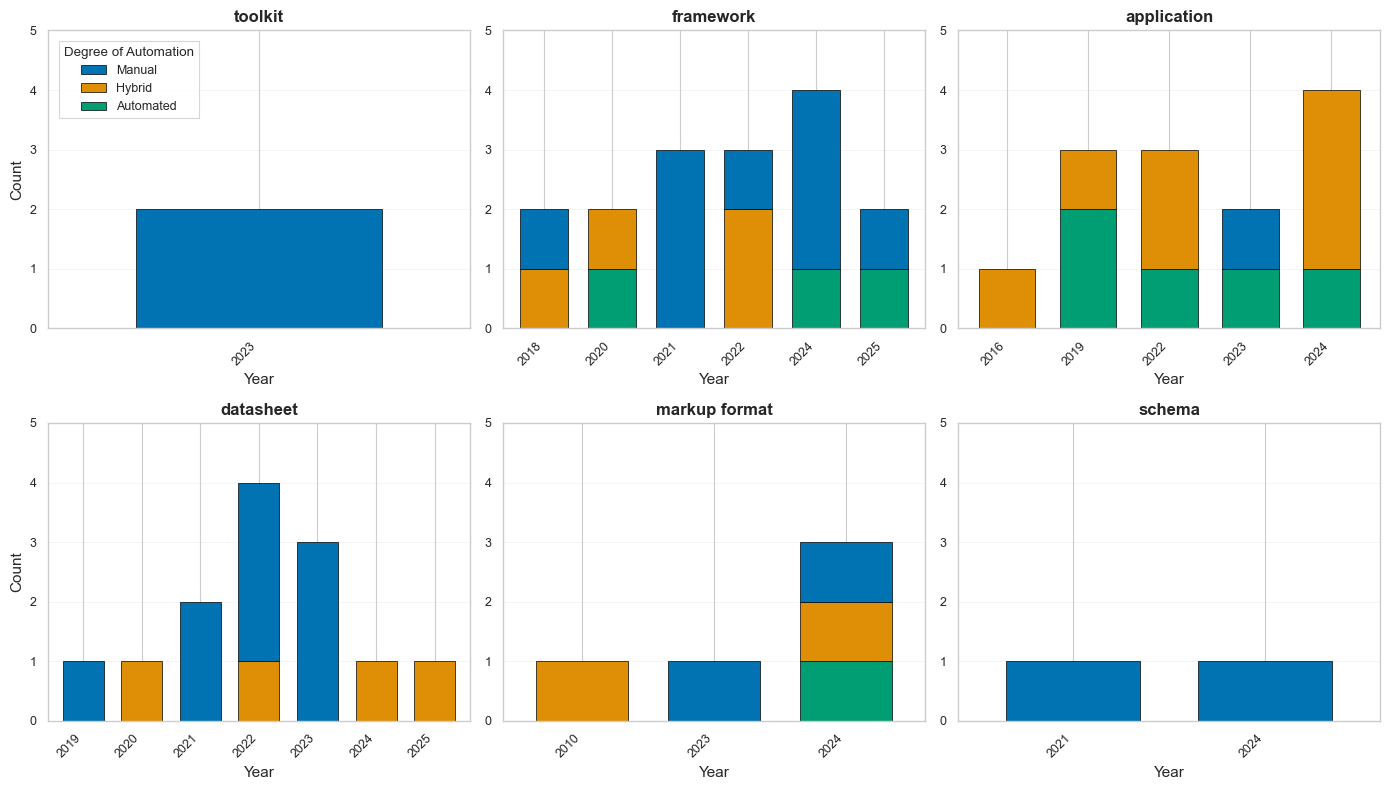

In [111]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

tool_descriptions = df_filtered['tool_description'].dropna().unique()
automation_degrees = df_filtered['degree_automation'].dropna().unique()
years = sorted(df_filtered['year'].dropna().unique())

automation_colors = dict(zip(automation_degrees, sns.color_palette("colorblind", n_colors=len(automation_degrees))))

max_count = 0
for tool in tool_descriptions:
    tool_data = df_filtered[df_filtered['tool_description'] == tool]
    if len(tool_data) > 0:
        counts = tool_data.groupby('year').size()
        max_count = max(max_count, counts.max() if len(counts) > 0 else 0)

n_tools = len(tool_descriptions)
n_cols = 3
n_rows = (n_tools + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for idx, tool in enumerate(tool_descriptions):
    ax = axes[idx]

    tool_data = df_filtered[df_filtered['tool_description'] == tool]

    if len(tool_data) > 0:
        count_data = tool_data.groupby(['year', 'degree_automation']).size().unstack(fill_value=0)

        for degree in automation_degrees:
            if degree not in count_data.columns:
                count_data[degree] = 0

        if not count_data.empty:
            count_data.plot(kind='bar', stacked=True, ax=ax,
                            color=[automation_colors.get(col, 'gray') for col in count_data.columns],
                            edgecolor='black', linewidth=0.5, width=0.7)
        else:
            ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                    ha='center', va='center', fontsize=10, color='gray')
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', fontsize=10, color='gray')

    ax.set_title(f'{tool}', fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count' if idx % 3 == 0 else '')


    ax.set_ylim(0, max_count + 1)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, min_n_ticks=max_count+1))

    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove individual plot legends
    if ax.get_legend():
        ax.legend().set_visible(False)

for idx in range(n_tools, len(axes)):
    axes[idx].set_visible(False)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=automation_colors[degree],
                                edgecolor='black', linewidth=0.5, label=degree)
                for degree in automation_degrees]
fig.legend(handles=legend_elements, title='Degree of Automation',
        loc='upper right', bbox_to_anchor=(0.15, 0.95), frameon=True, fancybox=False)

#   fig.suptitle('Distribution of level of automation across tools and across years',
#                fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Figure 2. Tool evaluation and integration across different types of tools

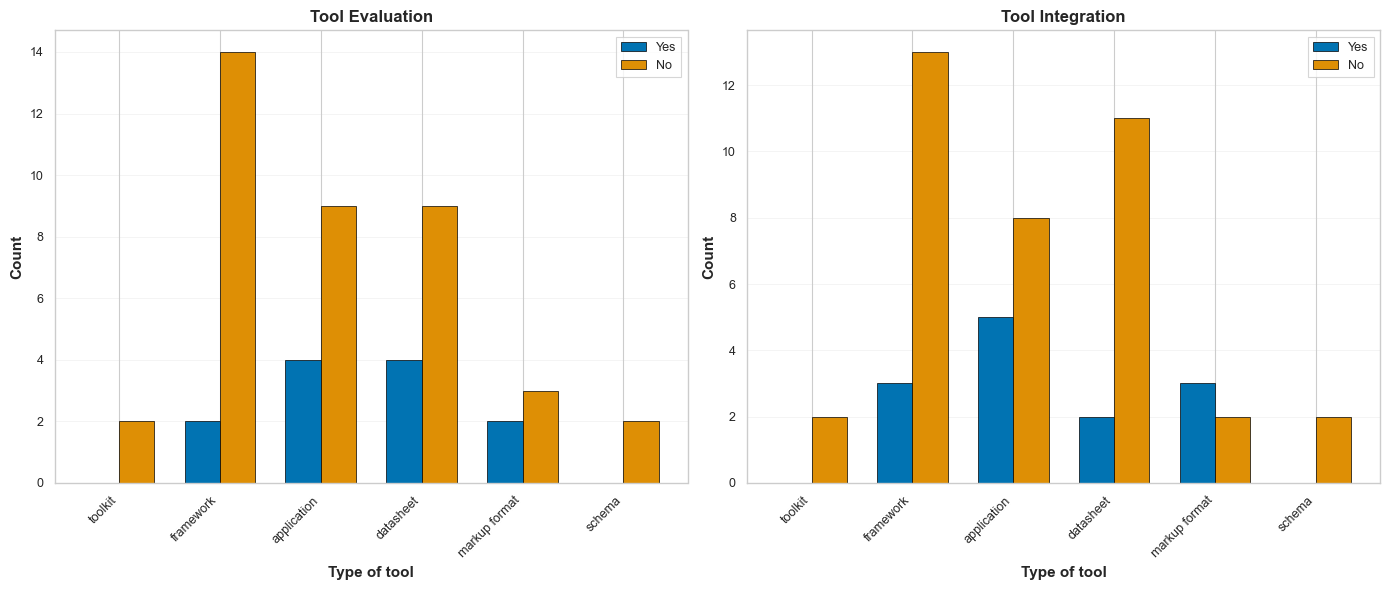

In [123]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

tool_descriptions = df_filtered['tool_description'].dropna().unique()

eval_yes = []
eval_no = []
integ_yes = []
integ_no = []

for tool in tool_descriptions:
    tool_data = df_filtered[df_filtered['tool_description'] == tool]
    eval_yes.append((tool_data['tool_evaluation'] == 'Yes').sum())
    eval_no.append((tool_data['tool_evaluation'] == 'No').sum())
    integ_yes.append((tool_data['tool_integration'] == 'Yes').sum())
    integ_no.append((tool_data['tool_integration'] == 'No').sum())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(tool_descriptions))
width = 0.35

bars1 = ax1.bar(x - width/2, eval_yes, width, label='Yes',
                color=sns.color_palette("colorblind")[0], edgecolor='black', linewidth=0.5)
bars2 = ax1.bar(x + width/2, eval_no, width, label='No',
                color=sns.color_palette("colorblind")[1], edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Type of tool', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Tool Evaluation', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(tool_descriptions, rotation=45, ha='right')
ax1.legend(frameon=True, fancybox=False)
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

bars3 = ax2.bar(x - width/2, integ_yes, width, label='Yes',
                color=sns.color_palette("colorblind")[0], edgecolor='black', linewidth=0.5)
bars4 = ax2.bar(x + width/2, integ_no, width, label='No',
                color=sns.color_palette("colorblind")[1], edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Type of tool', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Tool Integration', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(tool_descriptions, rotation=45, ha='right')
ax2.legend(frameon=True, fancybox=False)
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_axisbelow(True)
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# fig.suptitle('Comparison of Tool Evaluation and Integration',
#             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Figure 3. Appearance of different types of tools across the years

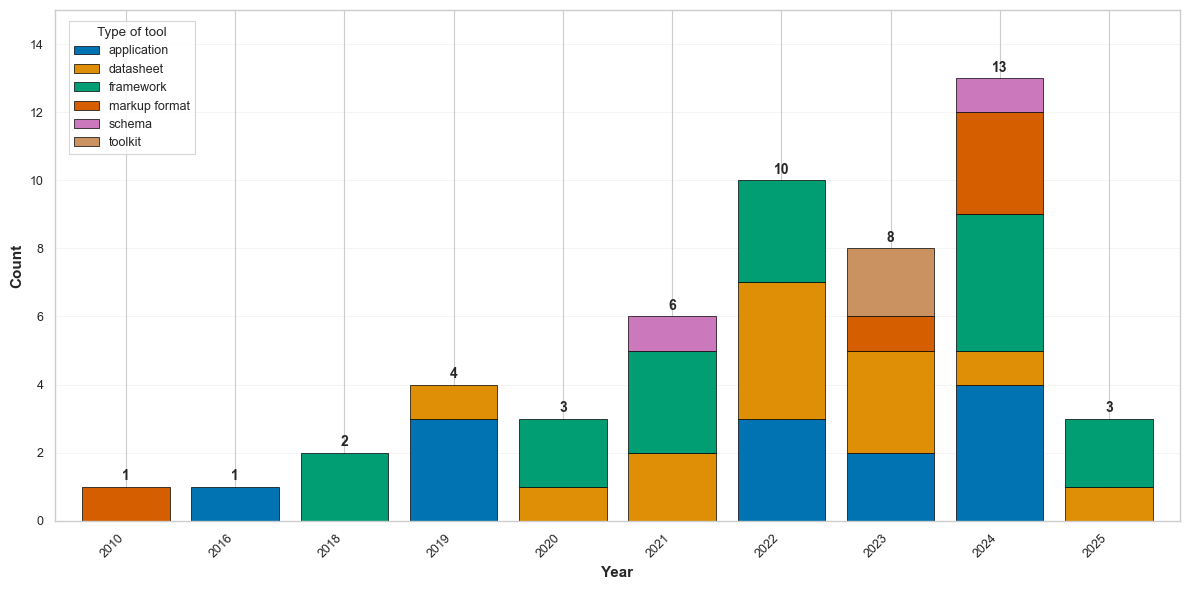

In [124]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

yearly_counts = df_filtered.groupby(['year', 'tool_description']).size().unstack(fill_value=0)

yearly_totals = yearly_counts.sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

bars = yearly_counts.plot(kind='bar', stacked=True, ax=ax, width=0.8,
                        color=sns.color_palette("colorblind", n_colors=len(yearly_counts.columns)),
                        edgecolor='black', linewidth=0.5)

for i, (year, total) in enumerate(yearly_totals.items()):
    ax.text(i, total + 0.1, str(int(total)),
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
# ax.set_title('Temporal Distribution of Tool Descriptions', fontweight='bold')
ax.legend(title='Type of tool', frameon=True, fancybox=False,
          loc='upper right', bbox_to_anchor=(0.13, 0.99),)
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, yearly_totals.max() + 2)  

plt.tight_layout()
plt.show()

# Figure 4. Distribution of types of proposals in relation to audiences

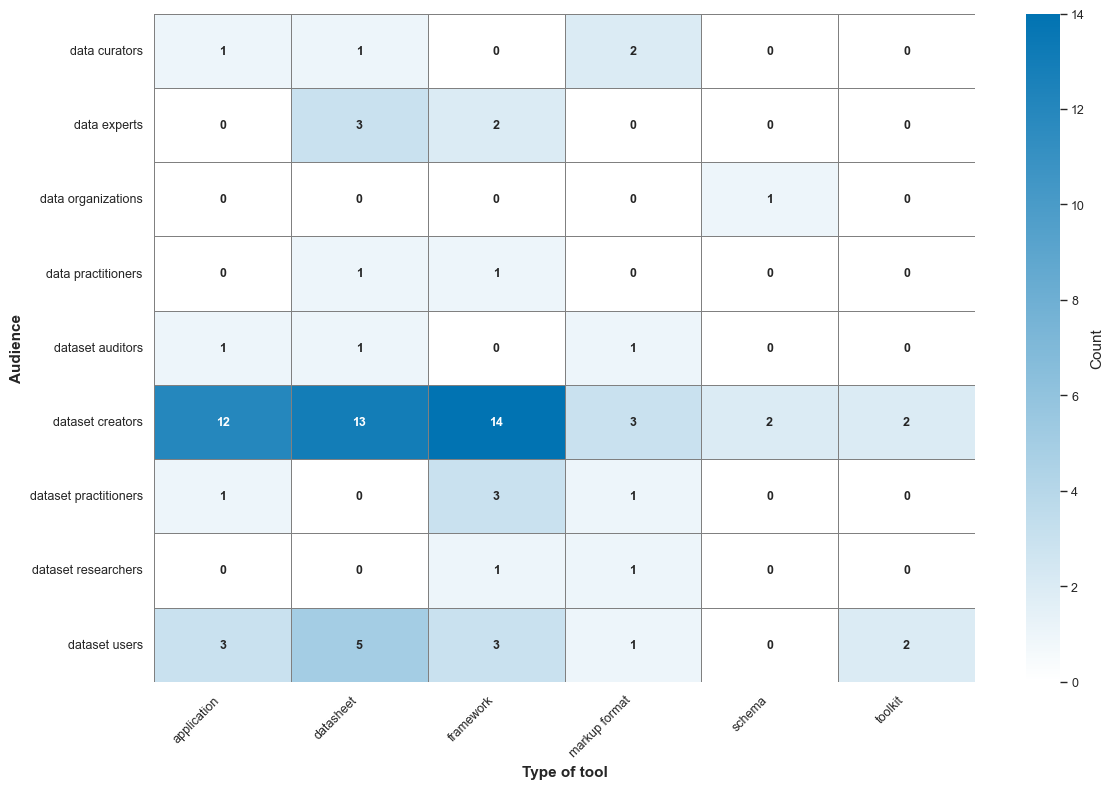

In [125]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

audience_list = []
for idx, row in df_filtered.iterrows():
    if pd.notna(row['audiences']):
        audiences = [a.strip() for a in str(row['audiences']).split(',')]
        for audience in audiences:
            audience_list.append({'tool_description': row['tool_description'],
                                'audience': audience})

audience_df = pd.DataFrame(audience_list)
if not audience_df.empty:
    audience_matrix = pd.crosstab(audience_df['audience'], audience_df['tool_description'])
else:
    audience_matrix = pd.DataFrame()

fig, ax = plt.subplots(figsize=(12, 8))

if not audience_matrix.empty:
    cmap = plt.cm.colors.LinearSegmentedColormap.from_list("", ["white", sns.color_palette("colorblind")[0]])

    sns.heatmap(audience_matrix, annot=True, fmt='d', cmap=cmap,
                cbar_kws={'label': 'Count'},
                linewidths=0.5, linecolor='gray',
                annot_kws={'fontsize': 9, 'fontweight': 'bold'},
                ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_xlabel('Type of tool', fontweight='bold')
ax.set_ylabel('Audience', fontweight='bold')
# ax.set_title('Distribution of Audiences Across Tool Descriptions', fontweight='bold')

plt.tight_layout()
plt.show()

# Figure 5. Distribution of level of automation of tools over time

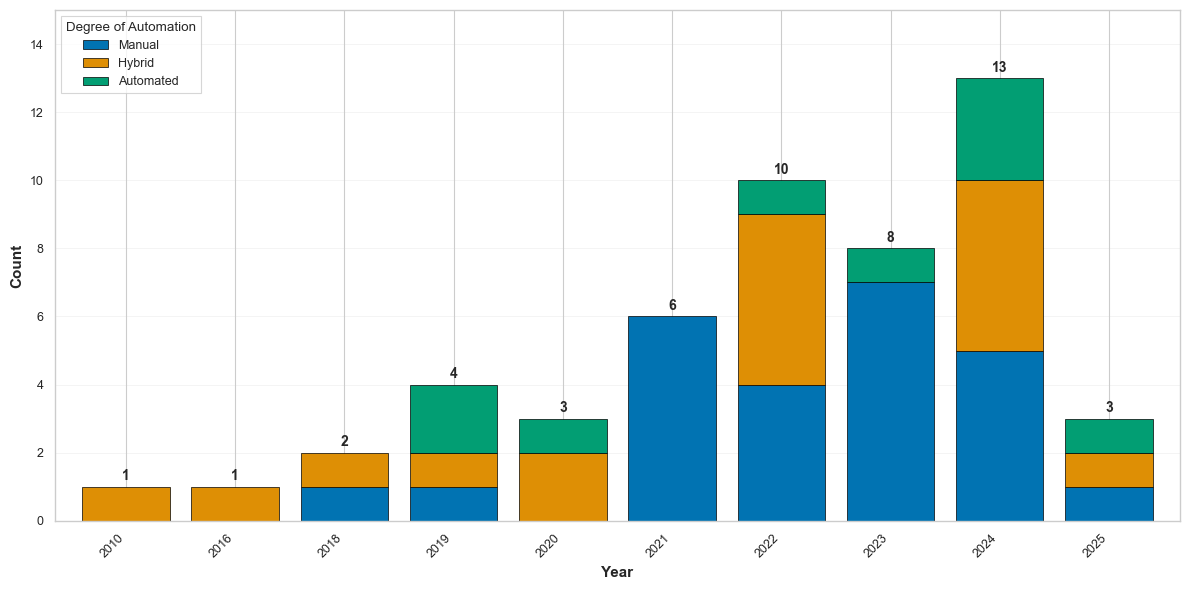

In [127]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

automation_yearly = df_filtered.groupby(['year', 'degree_automation']).size().unstack(fill_value=0)

automation_order = ['Manual', 'Hybrid', 'Automated']
automation_colors = {
    'Manual': sns.color_palette("colorblind")[0],
    'Hybrid': sns.color_palette("colorblind")[1],
    'Automated': sns.color_palette("colorblind")[2]
}

for degree in automation_order:
    if degree not in automation_yearly.columns:
        automation_yearly[degree] = 0
automation_yearly = automation_yearly[automation_order]

yearly_totals = automation_yearly.sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

automation_yearly.plot(kind='bar', stacked=True, ax=ax,
                        color=[automation_colors[col] for col in automation_yearly.columns],
                        edgecolor='black', linewidth=0.5, width=0.8)

for i, (year, total) in enumerate(yearly_totals.items()):
    ax.text(i, total + 0.1, str(int(total)),
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
#   ax.set_title('Automation over the years', fontweight='bold')
ax.legend(title='Degree of Automation', frameon=True, fancybox=False)
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, yearly_totals.max() + 2)  # Add space for labels

plt.tight_layout()
plt.show()

# Figure 6. Types of tools per audience, per year

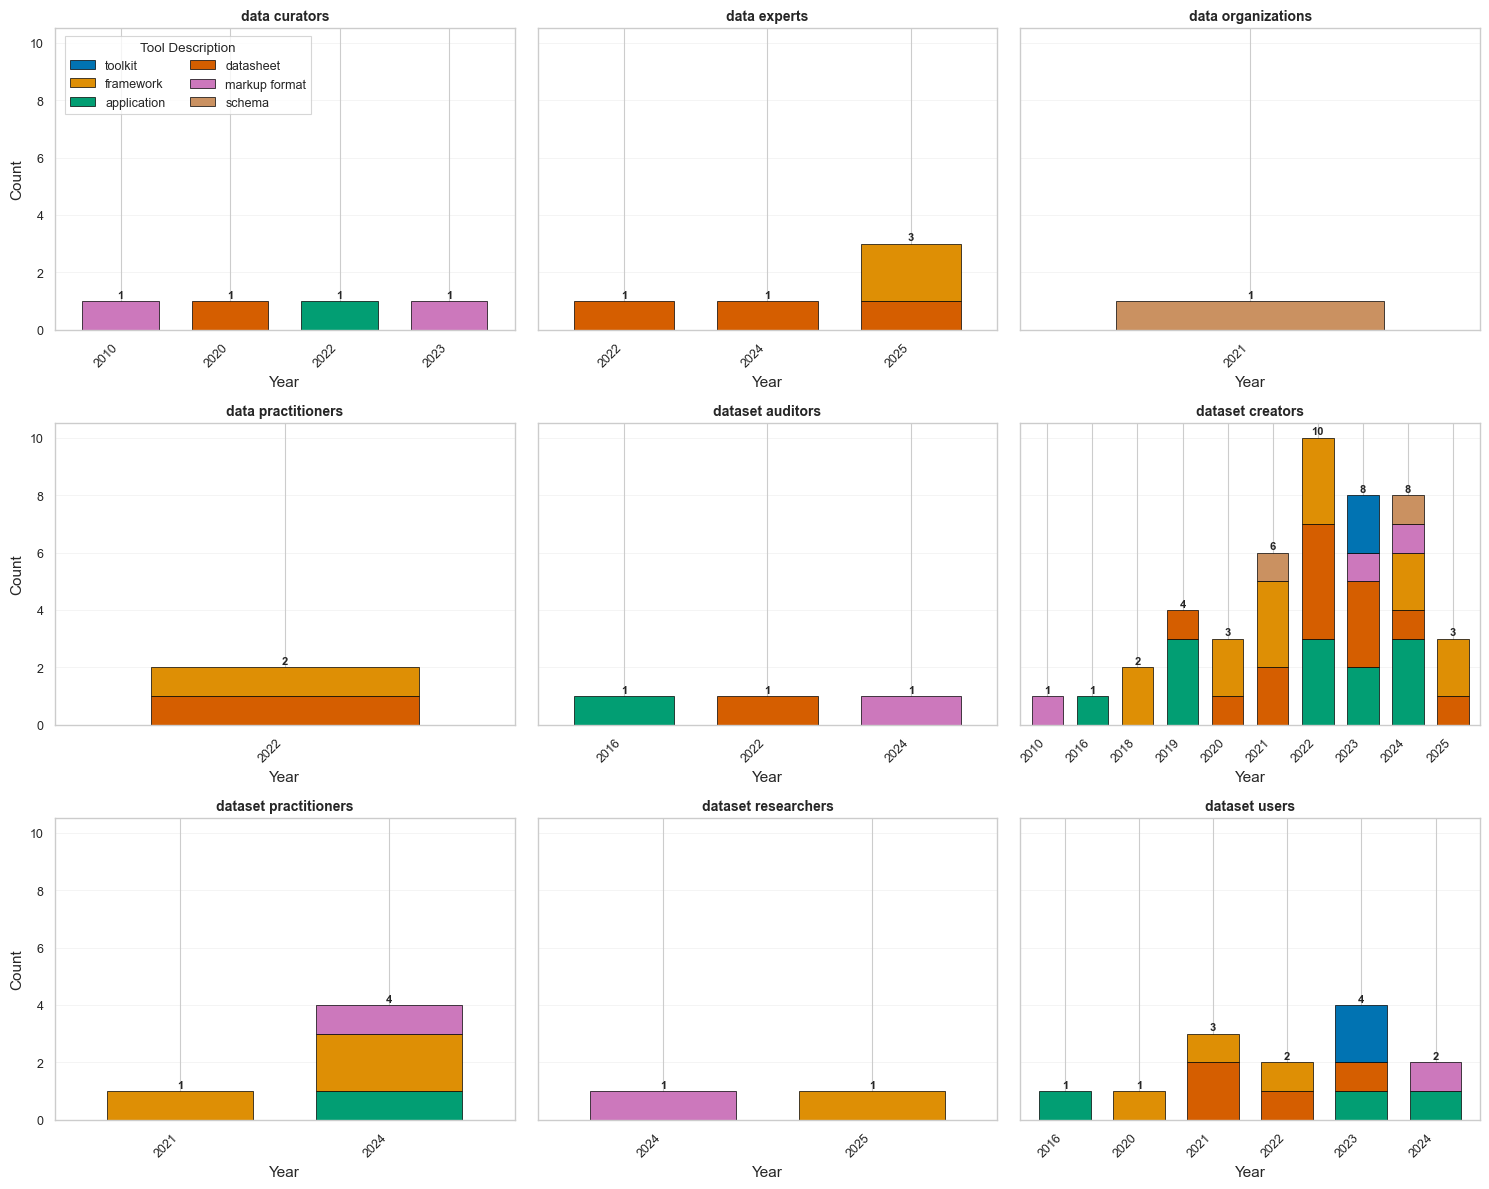

In [139]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

audience_set = set()
for audiences in df_filtered['audiences'].dropna():
    for audience in str(audiences).split(','):
        audience_set.add(audience.strip())

audience_list = sorted(list(audience_set))

n_audiences = len(audience_list)
n_cols = 3
n_rows = (n_audiences + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharey=True)
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

tool_descriptions = df_filtered['tool_description'].dropna().unique()
tool_colors = dict(zip(tool_descriptions, sns.color_palette("colorblind", n_colors=len(tool_descriptions))))

for idx, audience in enumerate(audience_list):
    ax = axes[idx]

    audience_data = []
    for _, row in df_filtered.iterrows():
        if pd.notna(row['audiences']) and audience in str(row['audiences']):
            audience_data.append(row)

    if audience_data:
        audience_df = pd.DataFrame(audience_data)

        counts = audience_df.groupby(['year', 'tool_description']).size().unstack(fill_value=0)

        counts.plot(kind='bar', stacked=True, ax=ax,
                    color=[tool_colors.get(col, 'gray') for col in counts.columns],
                    edgecolor='black', linewidth=0.5, width=0.7, legend=False)

        yearly_totals = counts.sum(axis=1)
        for i, total in enumerate(yearly_totals):
            if total > 0:
                ax.text(i, total + 0.05, str(int(total)),
                        ha='center', va='bottom', fontsize=8, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', fontsize=10, color='gray')

    display_audience = audience if len(audience) <= 25 else audience[:22] + '...'
    ax.set_title(f'{display_audience}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count' if idx % n_cols == 0 else '')
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for idx in range(n_audiences, len(axes)):
    axes[idx].set_visible(False)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=tool_colors[tool],
                                edgecolor='black', linewidth=0.5, label=tool)
                for tool in tool_descriptions]
fig.legend(handles=legend_elements, title='Tool Description',
        loc='upper right', bbox_to_anchor=(0.215, 0.97),
        frameon=True, fancybox=False, ncol=2)

#   fig.suptitle('Types of tools per audience over time',
#               fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Figure 7. Analysis of stakeholders mentioned vs. involved and integration efforts within stakeholders involved

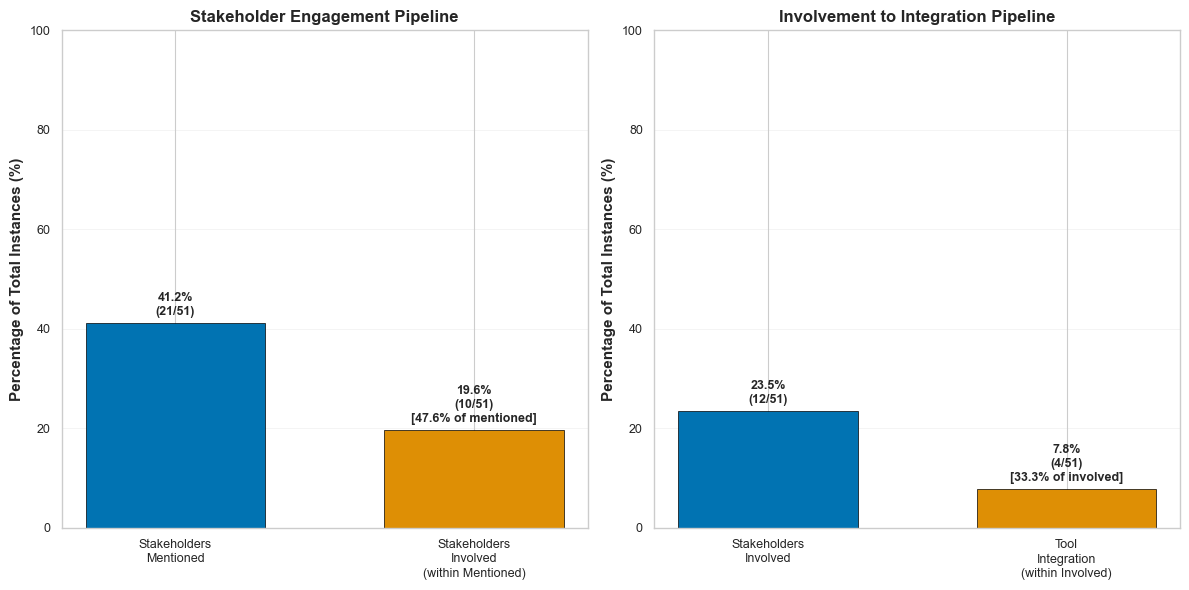

In [140]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']
total_instances = len(df_filtered)

# stakeholders mentioned
stakeholder_mentioned_yes = (df_filtered['stakeholders_mentioned'] == 'Yes').sum()
stakeholder_mentioned_pct = (stakeholder_mentioned_yes / total_instances) * 100

# stakeholders involved WITHIN those mentioned
df_mentioned = df_filtered[df_filtered['stakeholders_mentioned'] == 'Yes']
stakeholder_involved_within_mentioned = (df_mentioned['stakeholders_involved'] == 'Yes').sum()
# Calculate as percentage of total instances for consistent comparison
stakeholder_involved_within_mentioned_pct = (stakeholder_involved_within_mentioned / total_instances) * 100

# stakeholders involved (for second subplot)
stakeholder_involved_yes = (df_filtered['stakeholders_involved'] == 'Yes').sum()
stakeholder_involved_pct = (stakeholder_involved_yes / total_instances) * 100

# tool integration WITHIN stakeholders involved
df_involved = df_filtered[df_filtered['stakeholders_involved'] == 'Yes']
tool_integration_within_involved = (df_involved['tool_integration'] == 'Yes').sum()
tool_integration_within_involved_pct = (tool_integration_within_involved / total_instances) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

categories1 = ['Stakeholders\nMentioned', 'Stakeholders\nInvolved\n(within Mentioned)']
values1 = [stakeholder_mentioned_pct, stakeholder_involved_within_mentioned_pct]
counts1 = [stakeholder_mentioned_yes, stakeholder_involved_within_mentioned]
colors = sns.color_palette("colorblind", n_colors=2)

bars1 = ax1.bar(categories1, values1, color=colors, edgecolor='black', linewidth=0.5, width=0.6)
ax1.set_ylabel('Percentage of Total Instances (%)', fontweight='bold')
ax1.set_title('Stakeholder Engagement Pipeline', fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)
ax1.set_ylim(0, 100)

for i, (bar, pct, count) in enumerate(zip(bars1, values1, counts1)):
    if i == 0:
        label = f'{pct:.1f}%\n({count}/{total_instances})'
    else:
        conditional_pct = (stakeholder_involved_within_mentioned / stakeholder_mentioned_yes * 100) if stakeholder_mentioned_yes > 0 else 0
        label = f'{pct:.1f}%\n({count}/{total_instances})\n[{conditional_pct:.1f}% of mentioned]'
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            label, ha='center', va='bottom', fontweight='bold', fontsize=9)

categories2 = ['Stakeholders\nInvolved', 'Tool\nIntegration\n(within Involved)']
values2 = [stakeholder_involved_pct, tool_integration_within_involved_pct]
counts2 = [stakeholder_involved_yes, tool_integration_within_involved]

bars2 = ax2.bar(categories2, values2, color=colors, edgecolor='black', linewidth=0.5, width=0.6)
ax2.set_ylabel('Percentage of Total Instances (%)', fontweight='bold')
ax2.set_title('Involvement to Integration Pipeline', fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_axisbelow(True)
ax2.set_ylim(0, 100)

for i, (bar, pct, count) in enumerate(zip(bars2, values2, counts2)):
    if i == 0:
        label = f'{pct:.1f}%\n({count}/{total_instances})'
    else:
        conditional_pct = (tool_integration_within_involved / stakeholder_involved_yes * 100) if stakeholder_involved_yes > 0 else 0
        label = f'{pct:.1f}%\n({count}/{total_instances})\n[{conditional_pct:.1f}% of involved]'
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            label, ha='center', va='bottom', fontweight='bold', fontsize=9)

# fig.suptitle(f'Stakeholder and Integration Metrics (n={total_instances})',
#             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()